In [1]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

def calc_ecc_anomaly(M,ecc):
    E = M
    d = E - e*np.sin(E) - M
    while abs(d) > 1e-7:
        dE = d/(1 - e*np.cos(E))
        E = E - dE
        d = E - e*np.sin(E) - M
    return E

kf = 1                  # momentum relaxation time (days)
ka = 40                 # free troposphere relaxation time
ks = 4                  # boundary layer relaxation
ks_pole = 40            # boundary layer polar relax
ks_std = 0.5            # standard deviation of ks gaussian

kappa = 2/7
rdgas = 287.05
g = 9.81
sigma_b = 0.7           # boundary layer height
extra_stability = 0.6   # fractional difference from adiabatic

omega = 7.3e-5          # planetary rotation rate
p0 = 1000               # sea level pressure (hPa)
orbital_period = 360    # in days
a = 6.4e6               # planetary radius
albedo = 0.3
s0 = 1350               # planetary insolation

obliquity = np.deg2rad(23)
t_star = 5778           # stellar temperature
r_star = 696342         # stellar radius (km)
e = 0                   # eccentricity of orbit
sma = 150e6             # semi-major axis length (km)
peri_time = 180         # time at which planet is at periastron

lapse = 6.5             # troposphere lapse rate
h_a = 2                 # scale height for water vapour
tau = 5                 # optical depth at surface
c = 2*np.log(2)

In [2]:
class teq(object):
    """equilibrium temperature"""
    def __init__(self, size, obliquity=0.4, orb_period=360, albedo=0.3,
                 s0=1360, lapse=6.5, h_a=2, tau=5, time=0, hc=1, do_surface_hc=0):
        '''generates an equilibrium temperature field for the specified
        planetary setup'''
        self.size = size
        self.lats = np.linspace(-np.pi/2,np.pi/2,self.size[0])
        self.sigma = np.linspace(1,0.001,size[1])
        self.obliquity = obliquity
        self.orb_period = orb_period
        self.albedo = albedo
        self.s0 = s0
        self.lapse = lapse
        self.h_a = h_a
        self.tau = tau
        self.do_surface_hc = do_surface_hc
        self.hc = hc     # default value is a 1m mixed later ocean
             
        self.time = time
        self.teq = np.zeros(size)
        self.update_field()
        self.t_trop_mean = self.t_trop
        self.teq_mean = self.teq
        
        self.tg = np.ones(size[0])*250 #self.teq[:,0]
        self.prev_tg = np.ones(size[0])*250
               
    def step(self):
        self.time += 1
        self.update_field()
        if self.do_surface_hc == 1:
            self.calc_surface_hc()
        self.above_tropopause()
        self.t_trop_mean = (self.t_trop_mean
                            + (self.t_trop-self.t_trop_mean)/self.time)
        self.teq_mean = self.teq_mean + (self.teq-self.teq_mean)/self.time
        
    def calc_insolation(self):
        theta = 2*np.pi*self.time/self.orb_period
        self.dec = np.arcsin(np.sin(self.obliquity)*np.sin(theta))
        ihour_angle = np.clip(-np.tan(self.lats)*np.tan(self.dec),-1,1)
        hour_angle = np.arccos(ihour_angle)
        self.hour_angle = hour_angle
        # the factor of hour_angle/pi gives a diurnal average
        self.insol = (self.s0/np.pi*
                      (hour_angle*np.sin(self.lats)*np.sin(self.dec) + 
                       np.cos(self.lats)*np.cos(self.dec)*np.sin(hour_angle)))
        
    def update_field(self):
        '''perform basic update of the fields to a new time point'''
        rdgas = 287.05
        grav = 9.81
        self.calc_insolation()
        self.t_radbal = ((1-self.albedo)*self.insol/5.67e-8)**0.25        
        self.heights = rdgas*max((self.t_radbal+self.teq[:,0])/2)/grav*np.log(1/self.sigma)/1000
        self.t_trop = self.t_radbal/2**0.25
        self.h_trop = 1.0/(16*self.lapse)*(1.3863*self.t_trop +
                        np.sqrt((1.3863*self.t_trop)**2 +
                            32*self.lapse*self.tau*self.h_a*self.t_trop))
        self.h_diff = (np.tile(self.h_trop,(self.size[1],1)).transpose() - 
                                 np.tile(self.heights,(self.size[0],1)))
        self.h_tropi = np.argmin(abs(self.h_diff), axis=1)
        self.is_above_tp = (np.tile(self.h_trop,(self.size[1],1)).transpose() - self.heights)<0
        self.teq = (np.tile(self.t_trop,(self.size[1],1)).transpose() +
                    self.lapse*(-np.tile(self.heights,(self.size[0],1)) +
                                np.tile(self.h_trop,(self.size[1],1)).transpose()))
        self.ts = self.teq[:,0]
        
    def calc_surface_hc(self):
        dt = 86400
        c = self.hc*4.2e6
        self.prev_tg = self.tg
        # calculated using Forward in time Euler method
        self.tg = (5.67e-8*dt/c*(self.ts**4 - self.prev_tg**4) + self.prev_tg)
        # build teq back up with lapse rate under tp, constant above
        self.teq = np.empty(self.size)
        self.teq = (np.tile(self.tg,(self.size[1],1)).transpose() 
                    - self.lapse*np.tile(self.heights,(self.size[0],1)))
        # need to set new t_trop for use in the above_tropopause scheme
        for i in range(0,self.size[0]):
            self.t_trop[i] = self.teq[i,self.h_tropi[i]]
        
    def above_tropopause(self):
        '''apply some method to define the stratosphere in teq'''
        idx = np.where(self.is_above_tp)
        temp = np.tile(self.t_trop,(self.size[1],1)).transpose()
        self.teq[idx] = temp[idx]
        
    def strato_cap(self):
        '''apply a cap to the stratosphere temperatures'''
        t_strat = 250
        # really slow, iterative implementation just to check against fortran exactly
        for i in xrange(0,self.size[0]):
            for k in xrange(0,self.size[1]):
                h_above = self.heights[-1]-max(self.h_trop) #self.heights[-1]-self.h_trop[i]
                div1 = self.heights[-1] - 4/10*h_above
                div2 = self.heights[-1] - 8/10*h_above
                
                if self.heights[k] >= div1:
                    self.teq[i,k] = t_strat
                elif  div2 <= self.heights[k] < div1:
                    self.teq[i,k] = (t_strat-self.t_trop[i])/(div1-div2) * (self.heights[k]-div2) + self.t_trop[i]
                elif self.heights[k] >= self.h_trop[i]:
                    self.teq[i,k] = self.t_trop[i]
                    
        #end 
        
    def spin_up(self):
        '''execute steps until the ground temperature has reached equilibrium'''
        ym1 = np.zeros((self.size[0],self.orb_period))
        
        for i in range(0,self.orb_period):
            ym1[:,i] = self.tg
            self.step()
        
        error = sum(abs(self.tg - ym1[:,0]))
        print error
        i = 0
        while (error > 1) & (i < 10800):
            ym1[:,i%self.orb_period] = self.tg
            self.step()
            error = sum(abs(self.tg - ym1[:,i%self.orb_period]))
            #print error
            i += 1
        print i
        

In [ ]:
print t.heights
print t.t_trop

624.017731713
10800


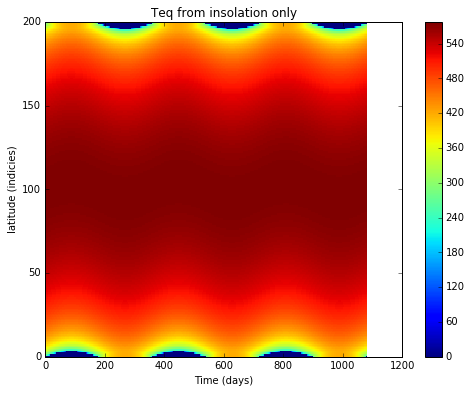

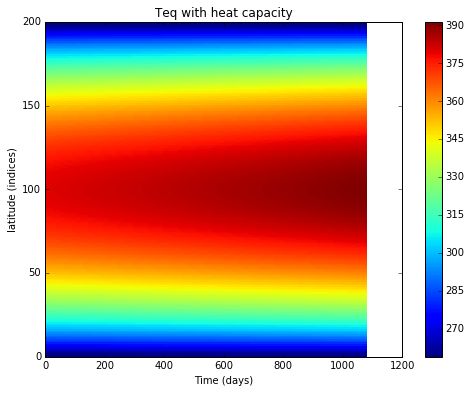

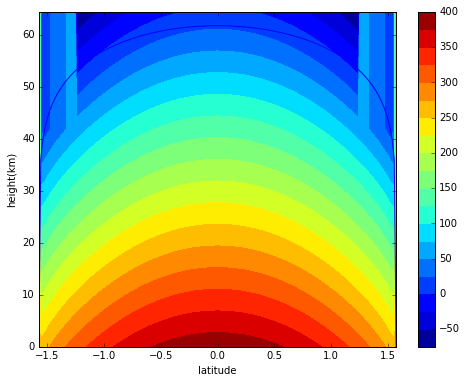

In [3]:
# check for Venus

t = teq((200,100), obliquity=0.05, albedo=0.75, tau=400, lapse=6, s0=2600, do_surface_hc=1, hc=10000)
mt = 1080
mt = 1080
t.spin_up()
times = np.arange(0,mt)
tg = np.empty((t.size[0],mt))
ts = np.empty((t.size[0],mt))
s = np.empty((t.size[0],mt))

for i in range(mt):
    t.step() 
    tg[:,i] = t.tg
    ts[:,i] = t.ts
    s[:,i] = t.insol

plt.pcolor(ts)
plt.colorbar()
plt.title('Teq from insolation only')
plt.xlabel('Time (days)')
plt.ylabel('latitude (indicies)')
plt.show()

plt.pcolor(tg)
plt.colorbar()
plt.title('Teq with heat capacity')
plt.xlabel('Time (days)')
plt.ylabel('latitude (indices)')
plt.show()

x,y = np.meshgrid(np.rad2deg(t.lats),t.heights)
plt.contourf(t.lats,t.heights,t.teq.transpose(),20)
plt.plot(t.lats,t.h_trop)
plt.colorbar()
plt.xlabel('latitude')
plt.ylabel('height(km)')
plt.show()

In [ ]:
#t = teq([200,20], time=90)
#t.t_trop.size
#t.step
#plt.plot(t.lats,t.teq[:,0])

t = teq((200,50),do_surface_hc=1, hc=200)
mt = 10800
times = np.arange(0,mt)
tg = np.empty((t.size[0],mt))
ts = np.empty((t.size[0],mt))
s = np.empty((t.size[0],mt))

for i in range(0,mt):
    t.step() 
    tg[:,i] = t.tg
    ts[:,i] = t.ts
    s[:,i] = t.insol

print(tg.max())
print(ts.max())
#print(t.t_trop_mean)
print(s.max())
print(1360/3 * 1.2)


In [ ]:
plt.pcolor(ts)
plt.colorbar()
plt.title('Teq from insolation only')
plt.xlabel('Time (days)')
plt.ylabel('latitude (indicies)')
plt.show()

plt.pcolor(tg)
plt.colorbar()
plt.title('Teq with heat capacity')
plt.xlabel('Time (days)')
plt.ylabel('latitude (indices)')
plt.show()

#lati = 0
#plt.plot(times,ts[lati,:],'b-',times,tg[lati,:],'r-')

x,y = np.meshgrid(np.rad2deg(t.lats),t.heights)
plt.contourf(t.lats,t.heights,t.teq.transpose(),20)
plt.plot(t.lats,t.h_trop)
plt.colorbar()
plt.xlabel('latitude')
plt.ylabel('height(km)')
plt.show()

plt.pcolor(t.teq.transpose())
plt.colorbar()
plt.xlabel('latitude')
plt.ylabel('height (indices)')
plt.show()

In [ ]:
print max(t.insol)
print 1360/3

In [ ]:
print(t.heights)
print(t.h_tropi)

print(t.t_trop)

In [ ]:
plt.pcolor(t.teq.transpose())
plt.colorbar()
plt.xlabel('latitude')
plt.ylabel('height (indices)')
plt.show()

t.strato_cap()

plt.pcolor(t.teq.transpose())
plt.colorbar()
plt.xlabel('latitude')
plt.ylabel('height (indices)')
plt.show()


In [ ]:
import numpy as np
a = np.zeros(10)
print(a)